<a href="https://colab.research.google.com/github/MaximilianLindholz/TSA_Example/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# You may need to run the pip install sktime command one cell down first
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sktime
import seaborn as sns
import sklearn

# sklearn stuff
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Sktime stuff
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope
from sktime.datasets import write_dataframe_to_tsfile
from sktime.datasets import load_from_tsfile_to_dataframe
import argparse
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.classification.kernel_based import RocketClassifier

In [2]:
# %pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 4.3 MB/s 


# Converter Function for our datasets from TimeEvalFormat

In [4]:
def get_anomaly_timeseries(input_classes_path, input_timeseries_path, output_path, anomaly_indicator_in_anomaly_file='is_anomaly', class_header='class', name='anomaly_classification_dataset', comment=None):
    """Converts from SVDB dataset to ts by extracting and labeling all anomalies.
    """
    labels = check_y(pd.read_csv(input_classes_path), class_header)
    df = pd.read_csv(input_timeseries_path)
    df = df.drop('timestamp', axis=1) if 'timestamp' in df.columns else df
    df_diff = (df[anomaly_indicator_in_anomaly_file].shift() !=
               df[anomaly_indicator_in_anomaly_file]).cumsum()
    result = np.ndarray((labels.shape[0], df.shape[1]-1), dtype=object)
    for i, row in enumerate(labels.values):
        idx = row[0]
        label = row[1]
        label_value = df_diff.loc[idx]
        k = df_diff[df_diff == label_value]
        first_idx = k.index[0]
        last_idx = k.index[-1]

        anomaly_overlaps = ((first_idx + last_idx) // 2) != idx
        if anomaly_overlaps:
            first_anomaly = min(abs(idx - first_idx), abs(idx - last_idx))
            assert first_idx == idx-first_anomaly or last_idx == idx+first_anomaly
            v = df.loc[idx-first_anomaly:idx+first_anomaly]
        else:
            v = df.loc[first_idx:last_idx]

        v = v.drop(anomaly_indicator_in_anomaly_file, axis=1)
        for j, el in enumerate(v.to_numpy().transpose()):
            result[i][j] = pd.Series(el)
    write_dataframe_to_tsfile(
        pd.DataFrame(result), output_path, class_value_list=labels[class_header], problem_name=name, comment=comment)


def check_y(y, class_header):
    if not isinstance(y, pd.DataFrame):
        y = pd.DataFrame(y)
    if class_header not in y.columns or 'index' not in y.columns:
        raise ValueError(
            f'Column {class_header} and "index" must be present in y')
    if y.columns.get_loc('class') != 1:
        raise ValueError('Column "class" must be the second column in y')
    if y.columns.get_loc('index') != 0:
        raise ValueError('Column "index" must be the first column in y')
    return y


Using sktime datasets

First example: classify different sports using K-nearest-neighbours classifier for time series // afterwards adaption to our asphalt dataset


In [8]:
from sktime.datasets import load_basic_motions

X, y = load_basic_motions(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, [0]], y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 1) (60,) (20, 1) (20,)


In [9]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['badminton' 'running' 'standing' 'walking'] [16 15 14 15]


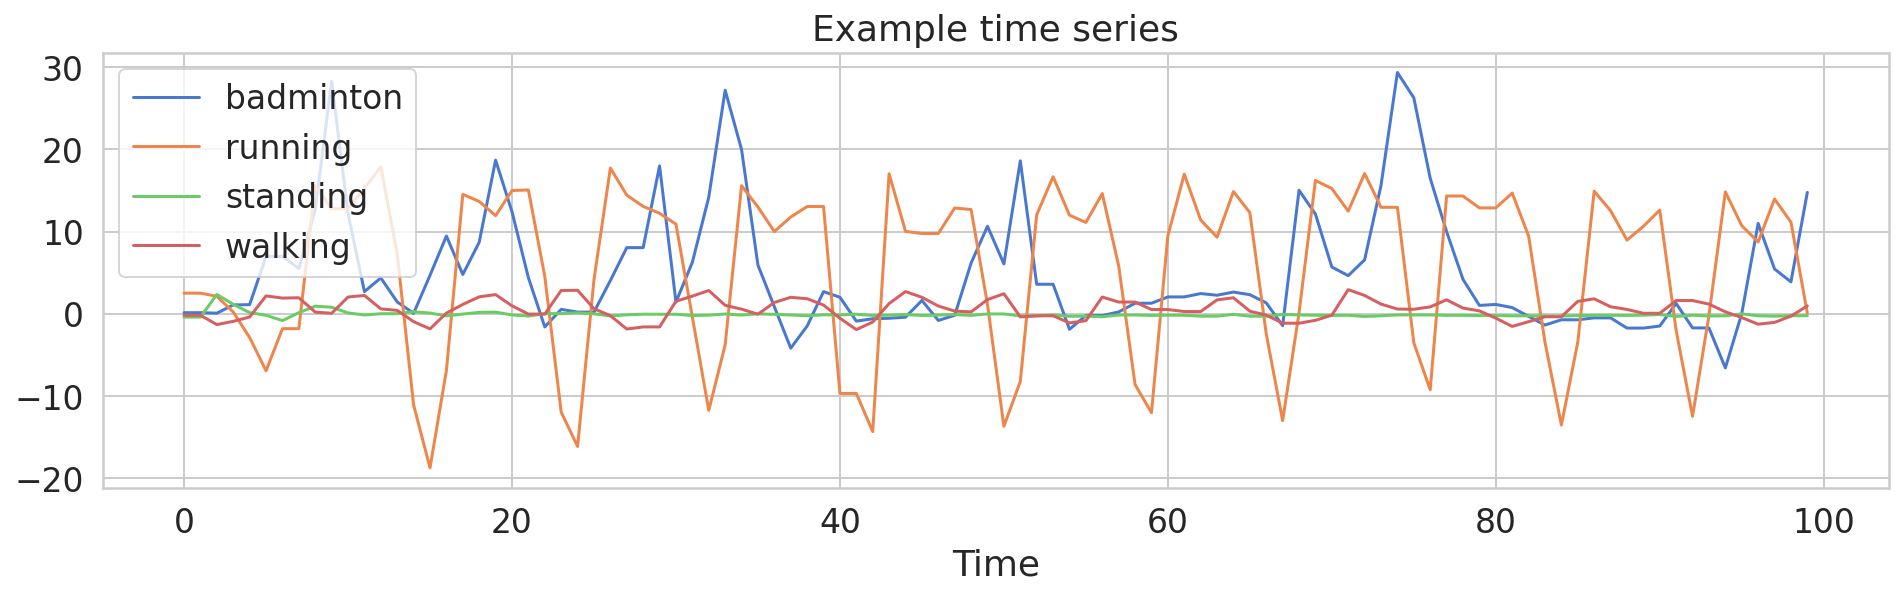

In [10]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=label)
plt.legend()
ax.set(title="Example time series", xlabel="Time");

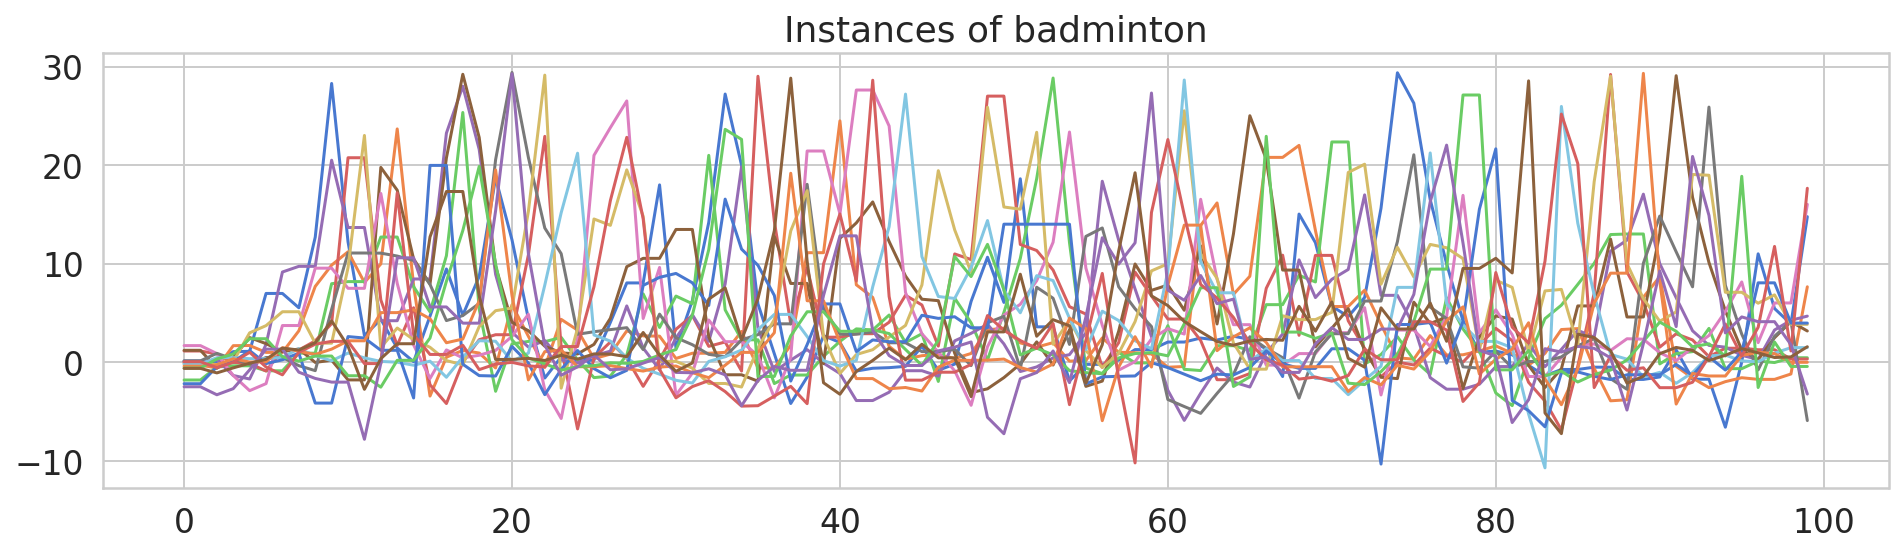

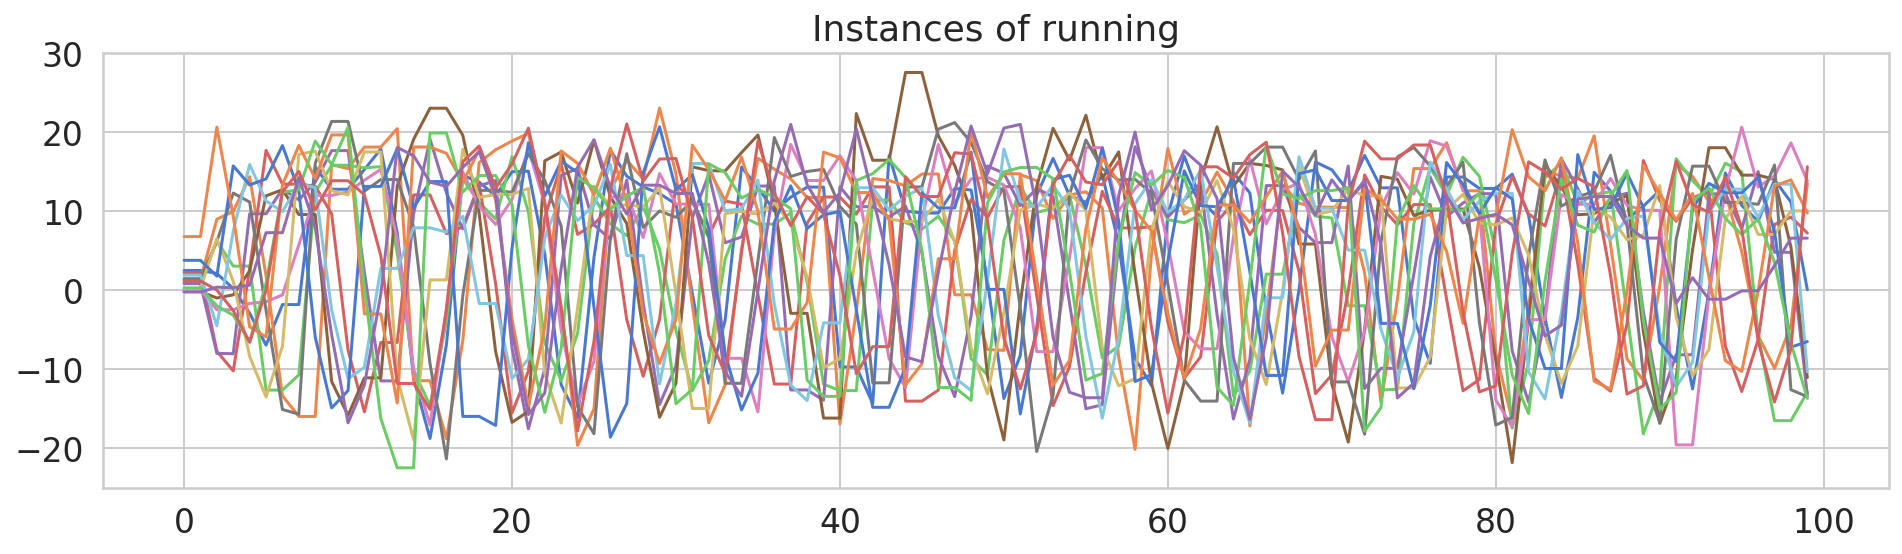

In [11]:
for label in labels[:2]:
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
    for instance in X_train.loc[y_train == label, "dim_0"]:
        ax.plot(instance)
    ax.set(title=f"Instances of {label}")

In [12]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

1.0

Mean Accuracy (knn.score) = 1 => Perfect :D! What a coincidence


Now adopt it for our asphalt data / u have to link the google colab to your drive or our drive or upload it manually before and adapt the path
first input .class, second regular, third output
Folder output structure looks hideous i know 💣

In [13]:
get_anomaly_timeseries('/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.train.classes.csv', '/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.train.csv', '/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.train.ts')
get_anomaly_timeseries('/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.test.classes.csv', '/content/drive/MyDrive/data_tsa/Asphalt//mixed-all.test.csv', '/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.test.ts')

Convert

In [21]:
df_train_x, df_train_y = load_from_tsfile_to_dataframe('/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.train.ts/anomaly_classification_dataset/anomaly_classification_dataset.ts', replace_missing_vals_with='NaN') 
df_test_x, df_test_y =load_from_tsfile_to_dataframe('/content/drive/MyDrive/data_tsa/Asphalt/mixed-all.test.ts/anomaly_classification_dataset/anomaly_classification_dataset.ts', replace_missing_vals_with='NaN') 

Padding => Equal length through 0s

In [23]:
padding = PaddingTransformer()
train_x_padded = padding.fit_transform(df_train_x)
test_x_padded = padding.fit_transform(df_test_x)

Using KNN

In [24]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
knn.fit(train_x_padded, df_train_y)
knn.score(test_x_padded, df_test_y)

0.75

Mean accuracy on asphalt dataset is 0.75 so not bad :) 🍹
